# Analyzing lottery jackpot number
## Author: Hoang Van Phan
This note shows an attempt at predicting the jackpot number for a Vietnamese lottery called Vietlott 6/45.

The website for the lottery is: https://vietlott.vn/vi/choi/mega-6-45/gioi-thieu-san-pham-6-45

## Lottery rules
The player picks 6 non-repeating numbers between 01 and 45 (inclusive). The jackpot number of each lot is picked by a computer, thrice per week. The player wins the jackpot if all 6 chosen numbers match the jackpot number. The order of these 6 numbers is not taken into account.

Other prizes depend on how many of the 6 player-picked numbers appear in the jackpot number. 5 matching numbers correspond to the first prize, 4 the second prize, and 3 the third and last prize.

## Past jackpot winning numbers
The winning numbers in the past were recorded from Vietlott's website by web scraping using the selenium package. The web scraping program is web_scrapping.py, and the winning numbers are stored in the file winning_number.csv. The csv file contains the numbers, date and lot number of the past 618 lots.

## Data pre-processing

#### Import packages and data

In the csv file, each jackpot number is represented by a string containing the 6 numbers. The string is pre-processed so that the data is more convenient to plot and analyze.

In [1]:
# Import packages
import random
import numpy as np
import scipy.stats as stats
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Save a list of nice looking colors
my_colors = plt.get_cmap('tab10')

# Import data
df = pd.read_csv("D:/github_fun_projects/vietlott/winning_number.csv", dtype=str)

# Reformat the data
df.columns = ["lot_number","jackpot_number"]
df.index = [s.split(' ')[1] for s in df["lot_number"]]
# split the jackpot_number column into 6 numbers
for i in range(6):
    df[f"num{i+1}"] = [int(s[(2*i):(2*i+2)]) for s in df["jackpot_number"]]

# Display column names
print(df.columns)

# Check if there are any duplicated winning numbers
win_num_unique = set(df["jackpot_number"])
if len(win_num_unique) == df.shape[0]:
    print("There are no duplicated winning numbers.")
else:
    print("There are duplicated winning numbers.")

# Convert the 6 numbers into numpy array
six_num = df.loc[:,"num1":"num6"].to_numpy().astype(np.int64)

Index(['lot_number', 'jackpot_number', 'num1', 'num2', 'num3', 'num4', 'num5',
       'num6'],
      dtype='object')
There are no duplicated winning numbers.


The jackpot numbers must also be converted to machine learning-compatible features. This is done so that the data can be used with high dimensional data visualization methods, and to train a machine learning model if needed.

Two simplest conversion approachess are: one) each number is represented by six features corresponding to the six numbers, and two) each number is represented by 45 features, with each feature being 1 or 0 if the six numbers contain the value corresponding to that feature or not. The second method should be more appropriate, because its features imply which numbers are picked to make up the jackpot number. On the other hand, the first method's features signify the magnitudes of the six numbers in ascending order, and are not as intuitive as the second method. For example, if all jackpot numbers contain the number 22, then the first method won't be able to pick out number 22 as an important feature, since number 22's position among the six numbers can change, depending on the magnitudes of the other 5 numbers.

In [2]:
# Make a new dataframe to store the features of winning numbers
df1 = pd.DataFrame(0, columns=[f"feature{s}" for s in range(1,46)], index=df.index)
for counter, value in enumerate(df1.index):
    df1.iloc[counter, df.loc[value,"num1":"num6"].to_numpy().astype(int)-1] = 1

# Display the feature names
print(df1.columns)

# Sort df1 by index
df1.sort_index(inplace=True)

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
       'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
       'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
       'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
       'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
       'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
       'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
       'feature37', 'feature38', 'feature39', 'feature40', 'feature41',
       'feature42', 'feature43', 'feature44', 'feature45'],
      dtype='object')


## Data characterization
Some characteristics of the data are plotted and compared to the expected uniform distribution, and to a set of losing numbers generated by Python RNG.

I will use the Chi-square test to see if the jackpot numbers follows the uniform distribution.

In [3]:
print(stats.chisquare(df1.sum(axis=0)))

Power_divergenceResult(statistic=41.61165048543688, pvalue=0.5745180973611544)


Because the P-value is high, the jackpot numbers are very likely to be randomly chosen.

Let us pretend that we did not know that the data was ramdomly chosen, and proceed with characterizing the data.

#### Number of even numbers
What is the probability distribution of the number of even numbers, $N_{even}$, among the winning number?

If the 6 numbers are picked randomly with uniform distribution, then the number of even number follows a hypergeometric distribution (since the numbers are picked without replacement):
\begin{equation}
  N_{even} \sim Hypergeom(n=6, N=45, K=22)
\end{equation}

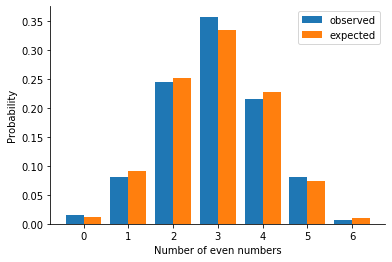

In [4]:
# Number of even numbers of each lot
num_even = (1 - (six_num % 2)).sum(axis=1)

# Plot observed vs expected
bar_width = 0.4
fig, ax = plt.subplots()
for i in range(7):
    # observed
    bar1 = ax.bar(i-bar_width/2, sum(num_even == i)/len(num_even), width=bar_width, color=my_colors(0))
    
    # expected
    bar2 = ax.bar(i+bar_width/2, stats.hypergeom.pmf(k=i,M=45,n=22,N=6), width=bar_width, color=my_colors(1))
ax.set_xlabel("Number of even numbers")
ax.set_ylabel("Probability")
ax.legend([bar1,bar2],["observed","expected"])
sns.despine(fig=fig)

The distribution of the number of even numbers follows the hypergeometric distribution very well. A noteable observation is that jackpot numbers with 3 even numbers are more frequent than expected. However, the pattern of the number of even numbers is unlikely to be predictive of the winning numbers.

#### Number of prime numbers
Similar to the number of even numbers, the number of prime numbers, $N_{prime}$, follows a hypergeometric distribution. There are 14 prime numbers between 1 and 45, and thus:
\begin{equation}
  N_{prime} \sim Hypergeom(n=6, N=45, K=14)
\end{equation}

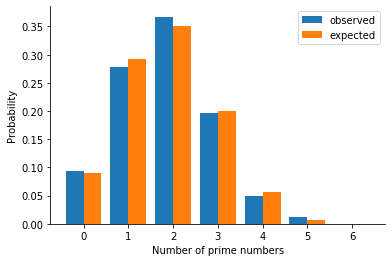

In [5]:
# Set of prime numbers between 1 and 45
prime_list = set([2,3,5,7,11,13,17,19,23,29,31,37,41,43])

# Number of prime numbers in each lot
num_prime = np.array([len(prime_list.intersection(set(s))) for s in six_num])

# Plot observed vs expected
bar_width = 0.4
fig, ax = plt.subplots()
for i in range(7):
    # observed
    bar1 = ax.bar(i-bar_width/2, sum(num_prime == i)/len(num_prime), width=bar_width, color=my_colors(0))
    
    # expected
    bar2 = ax.bar(i+bar_width/2, stats.hypergeom.pmf(k=i,M=45,n=14,N=6), width=bar_width, color=my_colors(1))
ax.set_xlabel("Number of prime numbers")
ax.set_ylabel("Probability")
ax.legend([bar1,bar2], ["observed","expected"])
sns.despine(fig=fig)

Again, the number of prime numbers is unlikely to be predictive.

#### Distribution of the values of the 6 numbers
In each lot, how many numbers are between 1 and 15, between 16 and 30, and between 31 and 45? These numbers $N_{1-15}, N_{16-30}, N_{31-45}$ also follow a hypergeometric distribution:
\begin{equation}
  N_{x-y} \sim Hypergeom(n=6, N=45, K=15)
\end{equation}

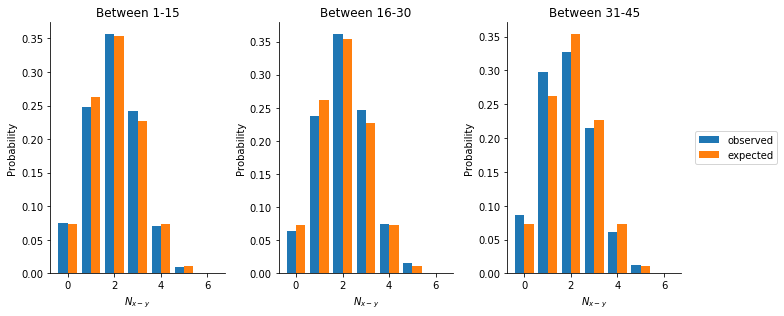

In [6]:
bar_width = 0.4
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11,4.5), tight_layout=True)
for i in range(3):
    temp_array = ((six_num>15*i) & (six_num<=15*(i+1))).sum(axis=1) # N_{x-y} of each lot
    for j in range(7):
        bar1 = ax[i].bar(j-bar_width/2, sum(temp_array==j)/six_num.shape[0],
                         width=bar_width, color=my_colors(0))
        bar2 = ax[i].bar(j+bar_width/2, stats.hypergeom.pmf(k=j,M=45,n=15,N=6), width=bar_width, color=my_colors(1))
    ax[i].set_xlabel(r"$N_{x-y}$")
    ax[i].set_ylabel("Probability")
    ax[i].set_title(f"Between {15*i+1}-{15*(i+1)}")
ax[-1].legend([bar1,bar2], ["observed","expected"], bbox_to_anchor=(1.05, 0.5), loc='center left')
sns.despine(fig=fig)

The highest difference between expected and observed is the number of jackpot numbers with only one number between 31-45.

#### Sum and product of the 6 numbers
I will now generate a set of non-jackpot numbers, then compare the sum and product of these numbers to the winning numbers'.

In [7]:
# Losing (non-jackpot) numbers
random.seed(123)
non_jackpot_num = [sorted(random.sample(range(1,46), 6)) for _ in range(5*df.shape[0])]

# Join the 6 six numbers of each non-winning lot into one string
non_jackpot_joined = set([''.join([f"{s2:02.0f}" for s2 in s1]) for s1 in non_jackpot_num])

# Remove jackpot numbers from non_jackpot_num
temp_set = non_jackpot_joined.difference(set(df["jackpot_number"]))

# Convert back to 6 number-format
non_jackpot_num = np.array([[int(s1[s2:(s2+2)]) for s2 in range(0,12,2)] for s1 in temp_set]).astype(np.int64)

# Convert non-jackpot numbers to machine learning features
df2 = pd.DataFrame(0, columns=[f"feature{s}" for s in range(1,46)], index=range(non_jackpot_num.shape[0]))
for counter in range(non_jackpot_num.shape[0]):
    df2.iloc[counter, non_jackpot_num[counter,:].astype(int)-1] = 1

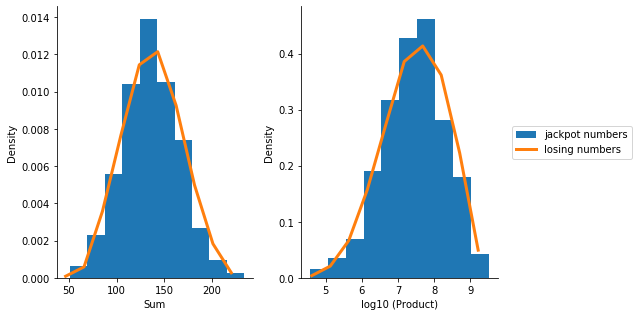

In [8]:
# Plot sum
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4.5), tight_layout=True)
ax[0].hist(six_num.sum(axis=1), density=True)
temp_hist = np.histogram(non_jackpot_num.sum(axis=1), density=True)
ax[0].plot([(temp_hist[1][i]+temp_hist[1][i+1])/2 for i in range(len(temp_hist[1])-1)], temp_hist[0], lw=3)
ax[0].set_xlabel("Sum")
ax[0].set_ylabel("Density")
# Plot product
hist1 = ax[1].hist(np.log10(six_num.prod(axis=1)), density=True, label="jackpot numbers")
temp_hist = np.histogram(np.log10(non_jackpot_num.prod(axis=1)), density=True)
hist2 = ax[1].plot([(temp_hist[1][i]+temp_hist[1][i+1])/2 for i in range(len(temp_hist[1])-1)],
           temp_hist[0], lw=3, label="losing numbers")
ax[1].set_xlabel("log10 (Product)")
ax[1].set_ylabel("Density")
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles[::-1], labels=labels[::-1], bbox_to_anchor=(1.05, 0.5), loc='center left')
sns.despine(fig=fig)

There is not a distinguishable characteristics of the jackpot winning numbers.

#### Number appearance frequency

Now I will check if any numbers appear more frequently than expected. If the six numbers are chosen randomly, then the distribution of a number n between 1 and 45 should be uniform with probability:
\begin{equation}
  Pr(n) = \frac{{44 \choose 5}}{{45 \choose 6}} \approx 0.13
\end{equation}
In other words, the probability equals the number of possible events of picking n among the six numbers, divided by the number of possible events of picking any six numbers. This equation can also be derived using the hypergeometric distribution.

The uncertainty in probability of picking a number n can be calculated using the binomial distribution:
\begin{equation}
  \text{Standard deviation}(Pr(n)) = \sqrt{\frac{Pr(n)(1-Pr(n))}{\text{Number of lots}}}
\end{equation}

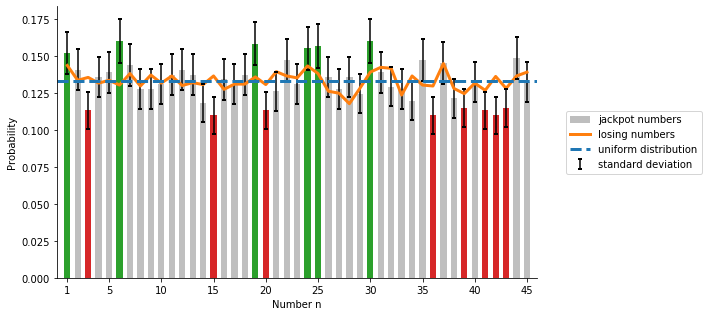

In [9]:
# Binomial standard deviation
sample_prop = df1.sum(axis=0)/df1.shape[0]
sample_sd = np.sqrt(sample_prop*(1-sample_prop)/df1.shape[0])

# Plot distribution of numbers
fig, ax = plt.subplots(figsize=(10,4.5), tight_layout=True)
ax.bar(range(1,46), sample_prop, width=0.6, label="jackpot numbers", color='grey', alpha=0.5)
ax.bar([1,6,19,24,25,30], sample_prop[np.array([1,6,19,24,25,30])-1], width=0.6, color=my_colors(2))
ax.bar([3,15,20,36,39,41,42,43], sample_prop[np.array([3,15,20,36,39,41,42,43])-1], width=0.6, color=my_colors(3))
ax.plot(range(1,46), df2.sum(axis=0)/df2.shape[0], label="losing numbers", lw=3, c=my_colors(1))
ax.errorbar(x=range(1,46), y=sample_prop, yerr=sample_sd, c="black", label="standard deviation",
            ls='None', capsize=2, capthick=2)
ax.axhline(scipy.special.comb(44,5,exact=True)/scipy.special.comb(45,6,exact=True),
           ls='--', lw=3, c=my_colors(0), label="uniform distribution")
ax.set_xlim(0,46)
ax.set_xticks([1,5,10,15,20,25,30,35,40,45])
ax.set_xticklabels([1,5,10,15,20,25,30,35,40,45])
ax.set_xlabel("Number n")
ax.set_ylabel("Probability")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[s] for s in [2,0,1,3]], labels=[labels[s] for s in [2,0,1,3]],
          bbox_to_anchor=(1.05, 0.5), loc='center left')
sns.despine(fig=fig)

Numbers 1, 6, 19, 24, 25 and 30 (green bars) appear more frequently than expected (more than 1 SD above uniform distribution). Numbers 3, 15, 20, 36, 39, 41, 42 and 43 (red bars) appear less frequently than expecte (more than 1 SD below uniform distribution).

Had I always picked the 6 numbers to be 1, 6, 19, 24, 25 and 30, would I have won anything at all?

In [10]:
# Hypothetical test number
test_num = [1, 6, 19, 24, 25, 30]

# List of won prizes, ordered by jackpot, first, second, third prize
prize_name = ["jackpot", "first", "second", "third"]
win_prize = [0, 0, 0, 0]
# Run through 3, 4, 5, 6 combinations:
for i in range(4):
    counter = 0
    for j in itertools.combinations(test_num, 6-i):
#         win_prize[i] += sum([''.join(list(j)) in s for s in df["jackpot_number"]])
        temp_array = np.ones((df1.shape[0],),dtype=bool)
        for k in j:
            temp_array = temp_array & (df1[f"feature{k}"] == 1).to_numpy()
        win_prize[i] += sum(temp_array)
        counter += 1
        if counter > 10:
            break
    print(f"Number of {prize_name[i]} prizes won: {win_prize[i]:.0f}")

Number of jackpot prizes won: 0
Number of first prizes won: 0
Number of second prizes won: 0
Number of third prizes won: 10


Each lottery lot costs 10,000 VND to play, and each third prize is worth 30,000 VND. This lottery strategy would have cost me 5,880,000 VND (approximately 250 USD).

Next, I will use a heatmap to check if the numbers are picked with any discernible patterns across lots.

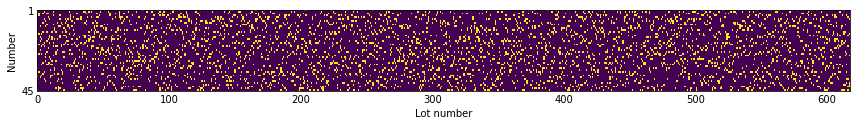

In [11]:
# Visualize the occurence of numbers 1-45 with a heatmap
fig, ax = plt.subplots(figsize=(12,4), tight_layout=True)
ax.imshow(df1.to_numpy().T)
ax.set_aspect(df1.shape[0]/df1.shape[1]/10)
ax.set_xlabel("Lot number")
ax.set_ylabel("Number")
ax.set_yticks([0,44])
ax.set_yticklabels([1,45])
ax.tick_params(axis='both', length=0)

The heatmap shows the pattern of each of the 45 numbers being chosen. If a number appears in the jackpot number of a particular lot, the corresponding pixel will appear yellow. The heatmap seems random. However, upon closer inspection, there seems to be "large pixels" on the heatmap, indicating that many numbers appear consecutively.

Let us inspect the first and last 200 lots.

Text(0.5, 1.0, 'Last 200 lots')

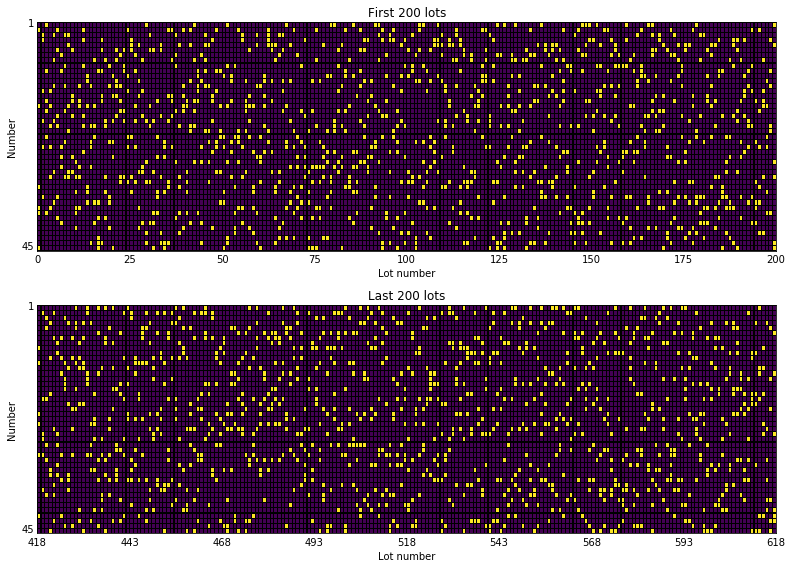

In [12]:
# Visualize the occurence of numbers 1-45 with a heatmap
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8), tight_layout=True)
# First 200 lots
ax[0].pcolormesh(df1.to_numpy()[:200,:].T, edgecolor="black", lw=0.05)
ax[0].invert_yaxis()
ax[0].set_aspect(df1.shape[0]/df1.shape[1]/10)
ax[0].set_xlabel("Lot number")
ax[0].set_ylabel("Number")
ax[0].set_yticks([0,44])
ax[0].set_yticklabels([1,45])
ax[0].tick_params(axis='both', length=0)
ax[0].set_title("First 200 lots")
# Last 200 lots
ax[1].pcolormesh(df1.to_numpy()[-200:,:].T, edgecolor="black", lw=0.05)
ax[1].invert_yaxis()
ax[1].set_aspect(df1.shape[0]/df1.shape[1]/10)
ax[1].set_xlabel("Lot number")
ax[1].set_ylabel("Number")
ax[1].set_yticks([0,44])
ax[1].set_yticklabels([1,45])
ax[1].set_xticklabels(np.arange(0,201,25)+(df1.shape[0]-200))
ax[1].tick_params(axis='both', length=0)
ax[1].set_title("Last 200 lots")

The large pixels are likely a visual artifact of separate pixels being squeezed and appearing close together. Thus, there is still no pattern to the heatmap.

Lastly, I want to see if any pairs of numbers appear more frequently than expected. The co-appearance probability of any two numbers is expected to be:
\begin{equation}
  Pr = \frac{{43 \choose 4}}{{45 \choose 6}} \approx 0.015
\end{equation}

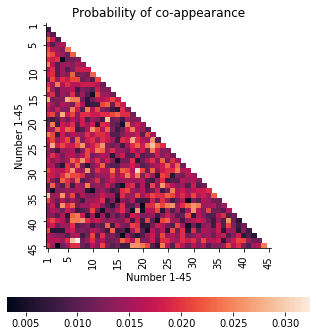

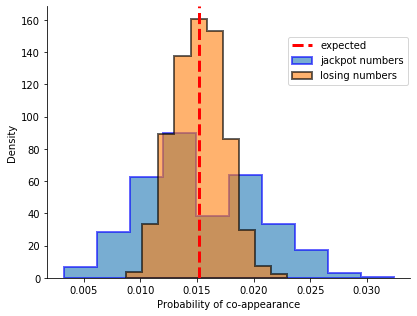

In [13]:
# Initialize a numpy array to store number of appearances of each pair
# The row and column indices correspond to the numbers in the pair
pair_num_jackpot = np.zeros((45,45)) # jackpot
pair_num_lose = np.zeros((45,45)) # losing numbers

# Loop through all possible number pairs
for i in itertools.combinations(range(45),2):
    pair_num_jackpot[i] += sum((df1[f"feature{i[0]+1}"]==1) & (df1[f"feature{i[1]+1}"]==1))
    pair_num_lose[i] += sum((df2[f"feature{i[0]+1}"]==1) & (df2[f"feature{i[1]+1}"]==1))
pair_num_jackpot /= df1.shape[0]
pair_num_lose /= df2.shape[0]

# Plot probability of co-appearance as heatmap
temp_plot = np.copy(pair_num_jackpot)
temp_plot[temp_plot == 0] = np.nan
fig, ax = plt.subplots(figsize=(4.5,5), tight_layout=True)
sns.heatmap(temp_plot.T, square=True, cbar_kws={"orientation": "horizontal"}, ax=ax)
ax.set_xticks(np.array([1,5,10,15,20,25,30,35,40,45])-1+0.5)
ax.set_xticklabels(np.array([1,5,10,15,20,25,30,35,40,45]))
ax.set_yticks(np.array([1,5,10,15,20,25,30,35,40,45])-1+0.5)
ax.set_yticklabels(np.array([1,5,10,15,20,25,30,35,40,45]))
ax.set_xlabel("Number 1-45")
ax.set_ylabel("Number 1-45")
ax.set_title("Probability of co-appearance")
sns.despine(fig=fig)

# Plot probability of co-appearance as scatter plot
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
temp_plot = temp_plot.reshape((-1,))
temp_plot = temp_plot[~np.isnan(temp_plot)]
ax.hist(temp_plot, density=True, histtype='stepfilled', **{"lw":2, "ec":'blue', "alpha":0.6}, label="jackpot numbers")
ax.axvline(scipy.special.comb(43,4)/scipy.special.comb(45,6), ls='--', c='red', lw=3, label="expected")
# Plot losing numbers
temp_plot2 = np.copy(pair_num_lose)
temp_plot2[temp_plot2 == 0] = np.nan
temp_plot2 = temp_plot2.reshape((-1,))
temp_plot2 = temp_plot2[~np.isnan(temp_plot2)]
ax.hist(temp_plot2, density=True, histtype='stepfilled', **{"lw":2, "ec":'black', "alpha":0.6}, label="losing numbers")
ax.set_xlabel("Probability of co-appearance")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(0.65, 0.8), loc='center left')
sns.despine(fig=fig)

In [14]:
# Show top 5 most and least likely pairs
print("Most likely pairs in jackpot:")
print([list(s+1) for s in np.where(pair_num_jackpot==np.max(temp_plot))])
print("Least likely pairs in jackpot:")
print([list(s+1) for s in np.where(pair_num_jackpot==np.min(temp_plot))])

Most likely pairs in jackpot:
[[7], [44]]
Least likely pairs in jackpot:
[[3, 4, 16, 20, 29], [45, 8, 43, 37, 36]]


The jackpot numbers seem to have pairs that appear significantly more likely or less likely than the losing numbers. To check if this is an artifiact of there being more losing numbers than jackpot numbers in the dataset, I will subset the losing numbers, such that each subset contains the same sample size as that of the jackpot number (618 numbers).

(618, 45)
(618, 45)
(618, 45)
(618, 45)
(618, 45)


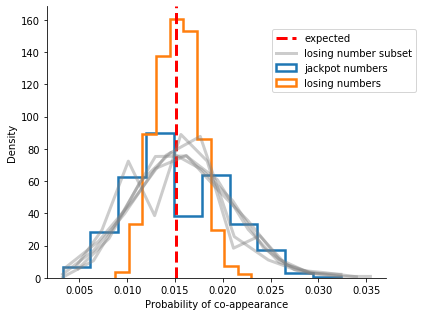

In [15]:
np.random.seed(123)
# Replot the histograms
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
ax.hist(temp_plot, density=True, histtype='step', **{"lw":2.5, "ec":my_colors(0)}, label="jackpot numbers")
ax.axvline(scipy.special.comb(43,4)/scipy.special.comb(45,6), ls='--', c='red', lw=3, label="expected")
ax.hist(temp_plot2, density=True, histtype='step', **{"lw":2.5, "ec":my_colors(1)}, label="losing numbers")

# Plot 5 subsets
for j in range(5):
    temp_subset = df2.iloc[np.random.choice(range(df2.shape[0]), size=df1.shape[0], replace=False),:].copy()
    print(temp_subset.shape)
    temp_pair_num = np.zeros((45,45))
    for i in itertools.combinations(range(45),2):
        temp_pair_num[i] += sum((temp_subset[f"feature{i[0]+1}"]==1) & (temp_subset[f"feature{i[1]+1}"]==1))
    temp_pair_num /= temp_subset.shape[0]
    temp_pair_num = temp_pair_num.reshape((-1,))
    temp_pair_num = temp_pair_num[temp_pair_num != 0]
    temp_hist = np.histogram(temp_pair_num, density=True)
    if j == 0:
        ax.plot([(temp_hist[1][i]+temp_hist[1][i+1])/2 for i in range(len(temp_hist[1])-1)],
                temp_hist[0], lw=3, color='grey', label="losing number subset", alpha = 0.4)
    else:
        ax.plot([(temp_hist[1][i]+temp_hist[1][i+1])/2 for i in range(len(temp_hist[1])-1)],
                temp_hist[0], lw=3, color='grey', alpha = 0.4)

ax.set_xlabel("Probability of co-appearance")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(0.65, 0.8), loc='center left')
sns.despine(fig=fig)

The difference between the jackpot and losing numbers' histograms is indeed caused by the sample size.

All the characterization so far has failed to show any distinguishable patterns of the jackpot numbers, which agree with the Chi-square test result above that the numbers are random. Let us proceed to high dimensional visualization (aka dimension reduction).

## High dimensional visualization

I will use PCA and TSNE to visualize the data to see if the jackpot numbers cluster separately from the losing numbers. For various datasets, t-SNE can resolve non-linear pattern that PCA can't.

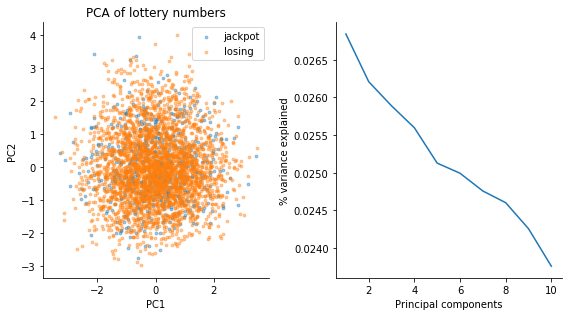

In [16]:
# Import visualization packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Combine jackpot and losing numbers into one data frame
ml_x = pd.concat([df1, df2]).to_numpy()

# Number label: 0 = loss, 1 = jackpot
ml_y = np.zeros(ml_x.shape[0])
ml_y[:df1.shape[0]] = 1
y_dict = {"jackpot":1, "losing":0}

# Standardize the data
ml_x_std = StandardScaler().fit_transform(ml_x)

# PCA
pca = PCA(n_components=10, random_state=456)
x_pca = pca.fit_transform(ml_x_std)

# Plot PCA
fig, ax = plt.subplots(ncols=2, figsize=(8,4.5), tight_layout=True)
for key, value in y_dict.items():
    ax[0].scatter(x_pca[ml_y==value,0], x_pca[ml_y==value,1], label=key, alpha=0.4, s=8)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[0].set_title("PCA of lottery numbers")
ax[0].legend()

# Plot component loading
ax[1].plot(np.arange(len(pca.explained_variance_))+1, pca.explained_variance_ratio_)
ax[1].set_xlabel("Principal components")
ax[1].set_ylabel("% variance explained")
sns.despine(fig=fig)

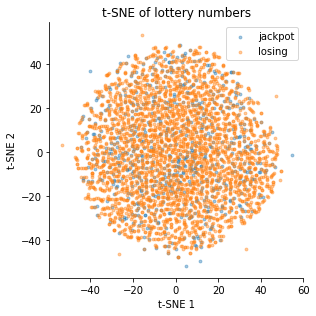

In [17]:
# t-SNE
tsne = TSNE(init='pca', perplexity=50, random_state=456)
x_tsne = tsne.fit_transform(ml_x_std)
# Plot t-SNE
fig, ax = plt.subplots(figsize=(4.5,4.5), tight_layout=True)
for key, value in y_dict.items():
    ax.scatter(x_tsne[ml_y==value,0], x_tsne[ml_y==value,1], label=key, alpha=0.4, s=8)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE of lottery numbers")
ax.legend()
sns.despine(fig=fig)

From the PCA plot and the variance explained of the PCs, it is obvious that the jackpot numbers are very similar to the losing numbers. t-SNE plot does not show any clear differences either, strongly suggesting that the jackpot numbers are similar to losing numbers in high dimensional space.

## Conclusion

The jackpot winning numbers are random. If PCA and/or t-SNE showed visual clustering of the jackpot numbers, I would try using machine learning to predict the jackpot numbers. Alas, this is not possible, and the Vietlott system cannot be gamed.